In [159]:
import pandas as pd
# read the data
adata1 = pd.read_csv("/Users/gengzhi/Desktop/单因素-唐都_副本.csv",index_col=0)
# add a column to the data,named obligate, value 1
adata2 = pd.read_csv("/Users/gengzhi/Desktop/单因素-外院_副本.csv",index_col=0)
# add a column to the data,named obligate, value 0
adata1['obligate'] = 1
adata2['obligate'] = 0
# bind the data 
adata = pd.concat([adata1,adata2])
# imputer the data
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
adata['RBC'] = imputer.fit_transform(adata[['RBC']])
# deleted the survival time and death
adata = adata.drop(labels=['生存时间','death(死亡)'],axis=1)

In [160]:
# separate the data rely on the 'SSUM(400domestic_4000onbroad)' column,die in 400 days get '1',else get '0'
t_test={}
columns = adata.columns.drop(labels=['SSUM(400domestic_4000onbroad)','reappear(复发)','surgical_classify','sex','stroke(术前是否)','TIA(术前是否)','hypertension','diabete','obligate'])
from scipy import stats
for i in columns:
    ttest = stats.ttest_ind(adata[adata['SSUM(400domestic_4000onbroad)']==1][i],adata[adata['SSUM(400domestic_4000onbroad)']==0][i])
    t_test[i] = ttest
print(t_test)


{'BMI': TtestResult(statistic=-4.00624010649433, pvalue=6.549456052259768e-05, df=1198.0), 'age': TtestResult(statistic=6.907058664120194, pvalue=8.012917596720795e-12, df=1198.0), 'WBC': TtestResult(statistic=4.518936118280962, pvalue=6.830046613396004e-06, df=1198.0), 'MONO': TtestResult(statistic=1.5351313208828454, pvalue=0.12501561543276254, df=1198.0), 'NEUT': TtestResult(statistic=5.503932492656549, pvalue=4.5394112698585485e-08, df=1198.0), 'PLT': TtestResult(statistic=-0.9102108284159875, pvalue=0.3628944263317956, df=1198.0), 'LYMPH': TtestResult(statistic=-4.461023522878223, pvalue=8.923582301764084e-06, df=1198.0), 'SII': TtestResult(statistic=5.573418836471535, pvalue=3.083361444946922e-08, df=1198.0), 'EO': TtestResult(statistic=-2.097703216128708, pvalue=0.03614045868921008, df=1198.0), 'BASO': TtestResult(statistic=-2.0125833667143813, pvalue=0.044381907672765175, df=1198.0), 'PDW': TtestResult(statistic=1.764896579495525, pvalue=0.07783590761641436, df=1198.0), 'MPV': 

In [161]:
# transform the t_test to the dataframe
t_test_df = pd.DataFrame(t_test,index=['t-statistic','p-value']).T

In [162]:
# output the result
t_test_df.to_csv("/Users/gengzhi/Desktop/t_test.csv")

In [163]:
# do chi-square test
strata= ['reappear(复发)','surgical_classify','sex','stroke(术前是否)','TIA(术前是否)','hypertension','diabete','obligate']
chi2_test = {}
from scipy.stats import chi2_contingency
for i in strata:
    chi2 = chi2_contingency(pd.crosstab(adata['SSUM(400domestic_4000onbroad)'],adata[i]))
    _,chi2_test[i],_,_ = chi2
print(chi2_test)

{'reappear(复发)': 0.049740096161027224, 'surgical_classify': 0.054699997246761, 'sex': 0.0024792249710231962, 'stroke(术前是否)': 0.873778924956086, 'TIA(术前是否)': 1.1012764155734602e-05, 'hypertension': 0.09111295124536807, 'diabete': 0.5918785860078122, 'obligate': 0.38178523088394545}


In [164]:
# transform the chi2_test to the dataframe
chi2_test_df = pd.DataFrame(chi2_test,index=['p-value']).T

In [165]:
# output the result
chi2_test_df.to_csv("/Users/gengzhi/Desktop/chi2_test.csv")

In [166]:
# retrival the columns names with p-value less than 0.05
columns = pd.concat([t_test_df[t_test_df['p-value']<0.05].index.to_frame(), chi2_test_df[chi2_test_df['p-value']<0.05].index.to_frame()])
columns = columns.index.append(pd.DataFrame(index=["SSUM(400domestic_4000onbroad)"]).index)

In [167]:
# retain the data in adata with the columns names
adata = adata[columns]

In [168]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
df = adata.copy()
# divide the data into X and y
X = df.drop(['SSUM(400domestic_4000onbroad)'], axis=1)
y = df['SSUM(400domestic_4000onbroad)']

Optimal number of features: 34
Selected features: ['BMI', 'age', 'WBC', 'NEUT', 'LYMPH', 'SII', 'EO', 'BASO', 'PCT', 'RBC', 'HGB', 'HCT', 'MCHC', 'RDW', 'PT', 'FDP', 'D_D', 'AST_ALT', 'A_G', 'TBIL', 'D_BIL', 'I_BIL', 'ALP', 'CO2', 'BUN', 'Cr', 'eGFR_CKD', 'UREA', 'CK', 'LDH', 'a_HBDH', 'GLU', 'CRP', 'TIA(术前是否)']


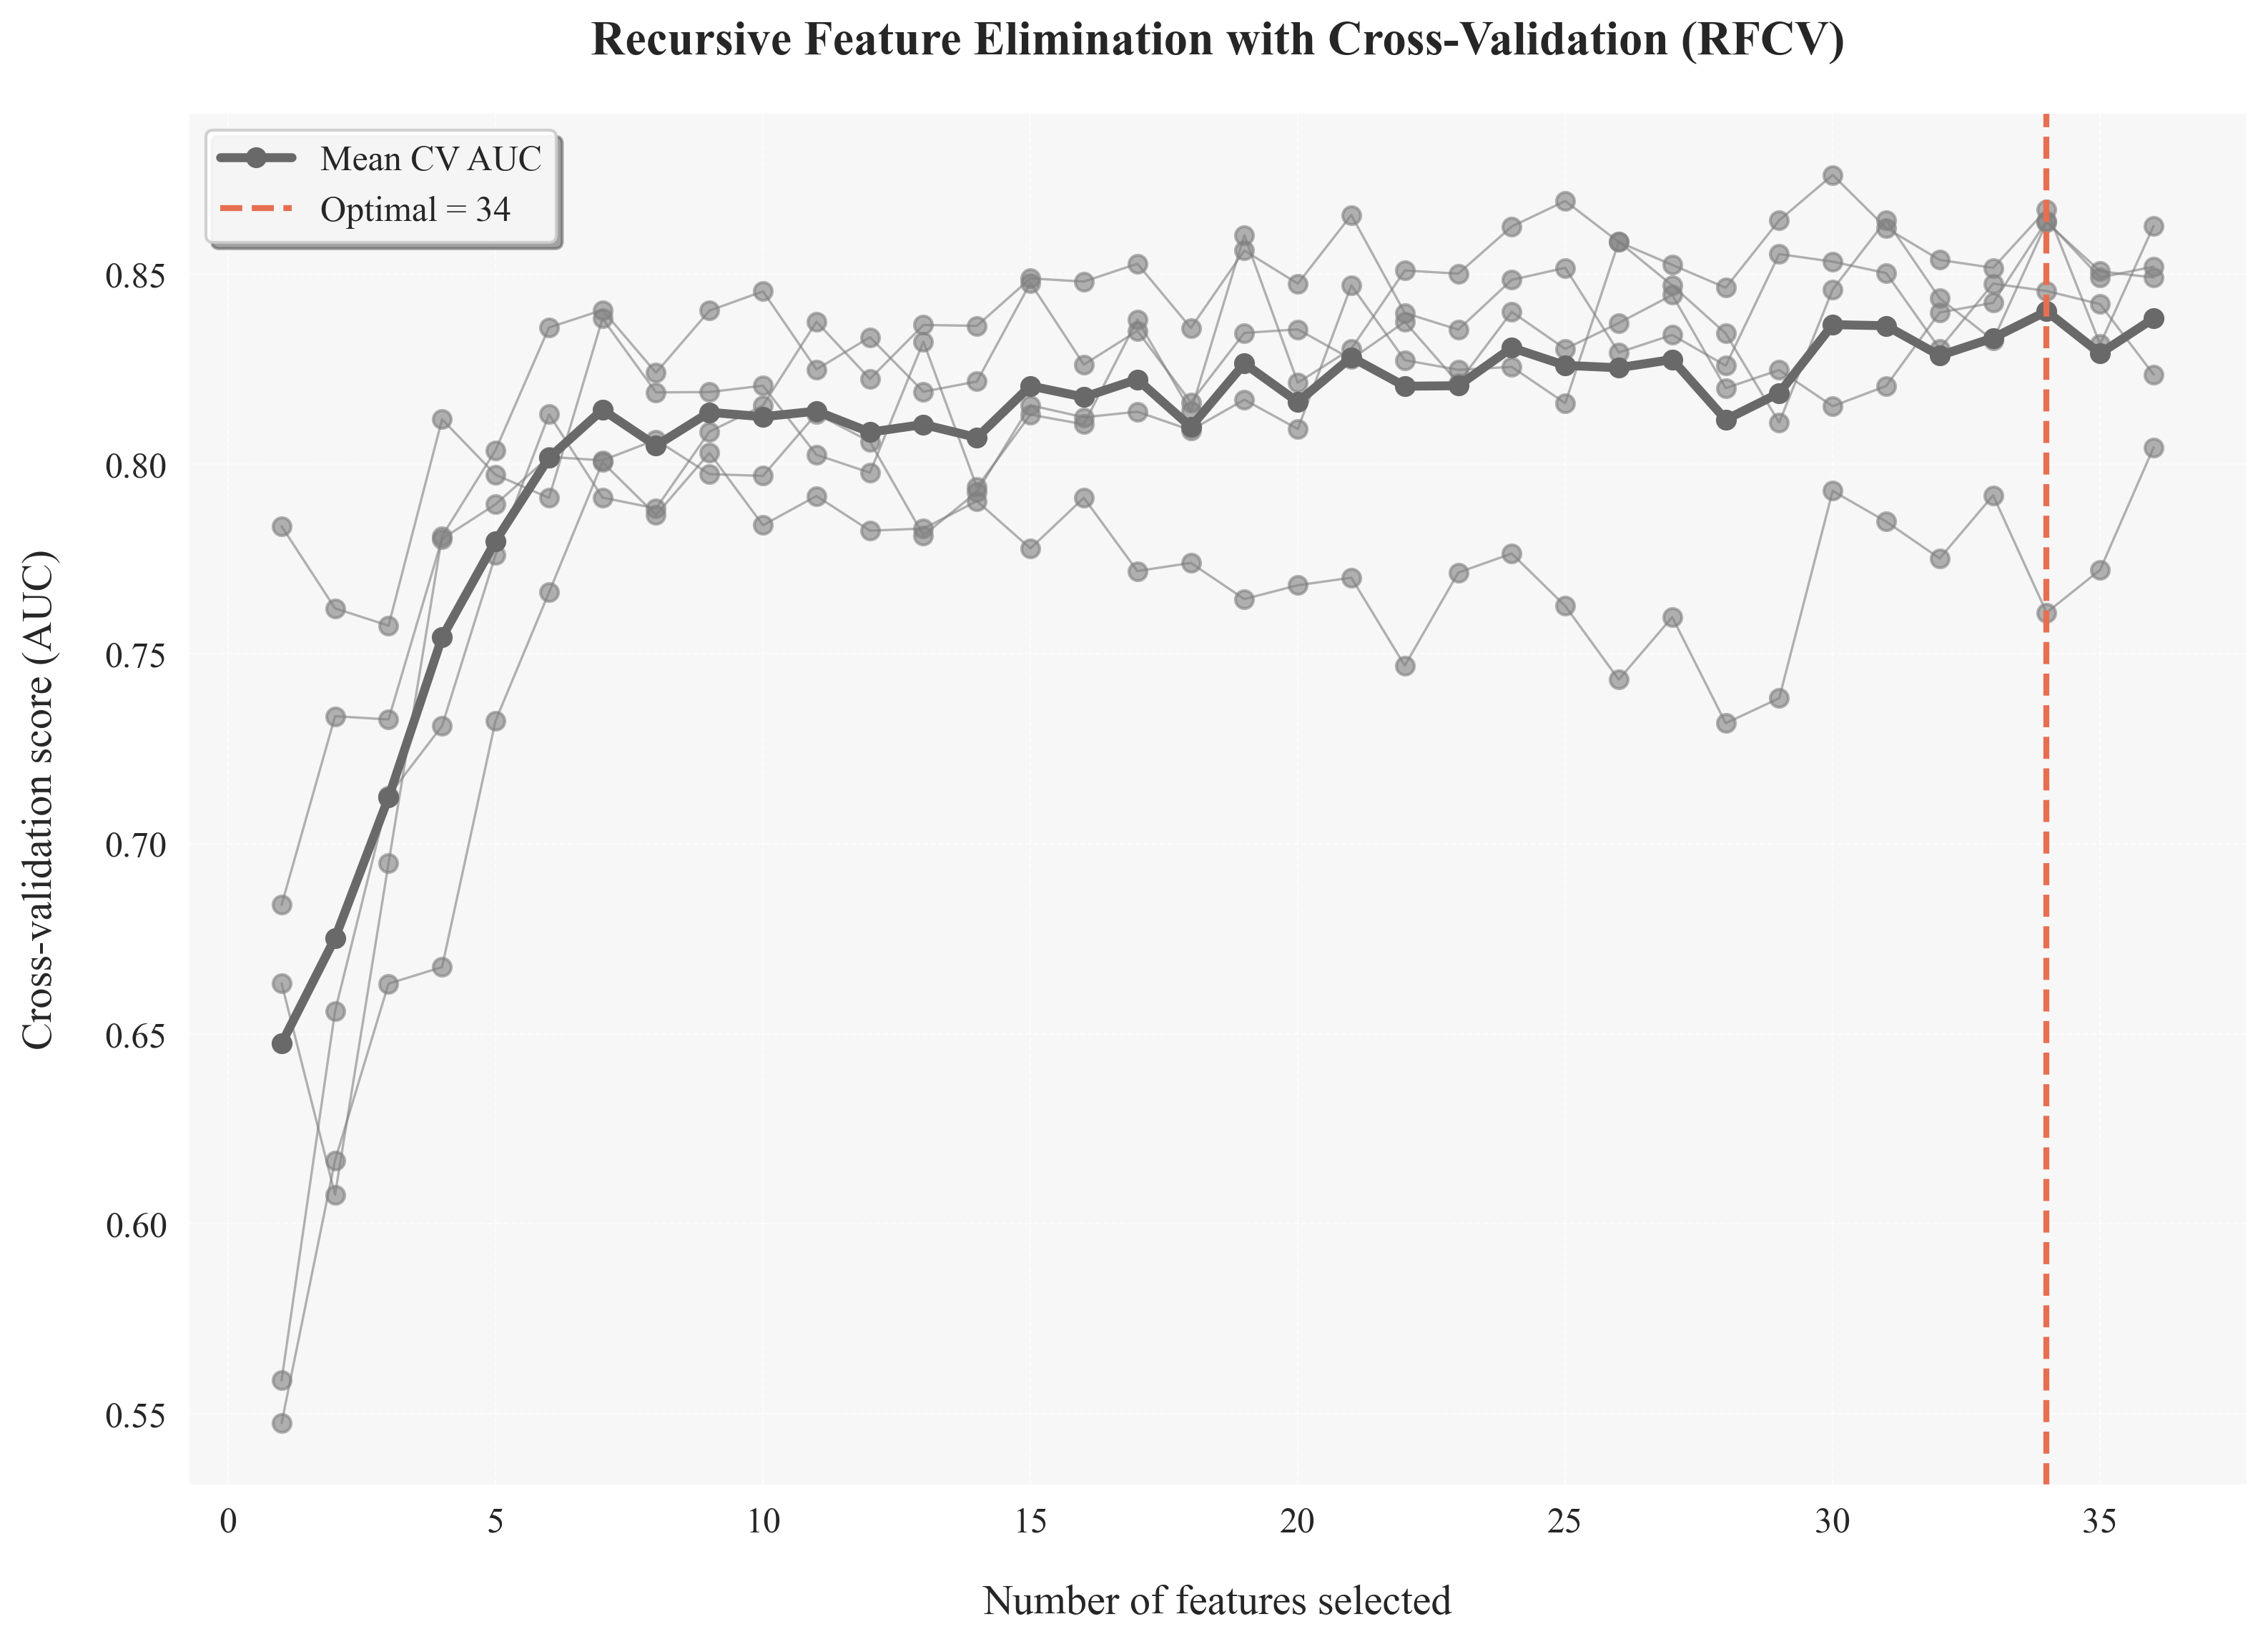

In [169]:
# import the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
# initialize the model
clf = RandomForestClassifier(random_state=123456)

# fold number
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
# define AUC as the scoring metric

# rfecv
rfecv = RFECV(estimator=clf, step=1, cv=cv, scoring='roc_auc')
rfecv.fit(X, y)

# print the optimal number of features
print(f"Optimal number of features: {rfecv.n_features_}")

# get the cross-validation results
cv_results = rfecv.cv_results_

# get the cross-validation scores
fold_scores = [cv_results[f'split{i}_test_score'] for i in range(5)]
mean_scores = cv_results['mean_test_score']  # calculate the mean of the 5 scores
# output the selected features
selected_features = X.columns[rfecv.support_]
print(f"Selected features: {list(selected_features)}")
df_selected = df[selected_features]
df_selected.head()
plt.figure(figsize=(12, 8), dpi=300)
plt.title('Recursive Feature Elimination with Cross-Validation (RFCV)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=15)
plt.ylabel('Cross-validation score (AUC)', fontsize=14, labelpad=15)
# set the background color of the plot
plt.gca().set_facecolor('#f7f7f7')
# plot the grey lines
for i in range(5):
    plt.plot(range(1, len(fold_scores[i]) + 1), fold_scores[i], marker='o', color='gray', linestyle='-',
             linewidth=0.8, alpha=0.6)
# plot the black line
plt.plot(range(1, len(mean_scores) + 1), mean_scores, marker='o', color='#696969', linestyle='-',
         linewidth=3, label='Mean CV AUC')
# plot the indicate line
plt.axvline(x=rfecv.n_features_, color='#E76F51', linestyle='--', linewidth=2, label=f'Optimal = {rfecv.n_features_}')
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, facecolor='white', framealpha=0.9)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('rfecv.png')

In [170]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(df_selected, y, test_size=0.21, random_state=5960)
# process df_selected with SMOTE+ENN
from imblearn.combine import SMOTEENN
# initialize the SMOTE+ENN
smote_enn = SMOTEENN(random_state=123456)
# process the data
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [171]:
# train the model use LR
from sklearn.linear_model import LogisticRegression
# initialize the model
lr = LogisticRegression(random_state=123456)
# train the model
# scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)
lr.fit(X_resampled, y_resampled)

LogisticRegression(random_state=123456)

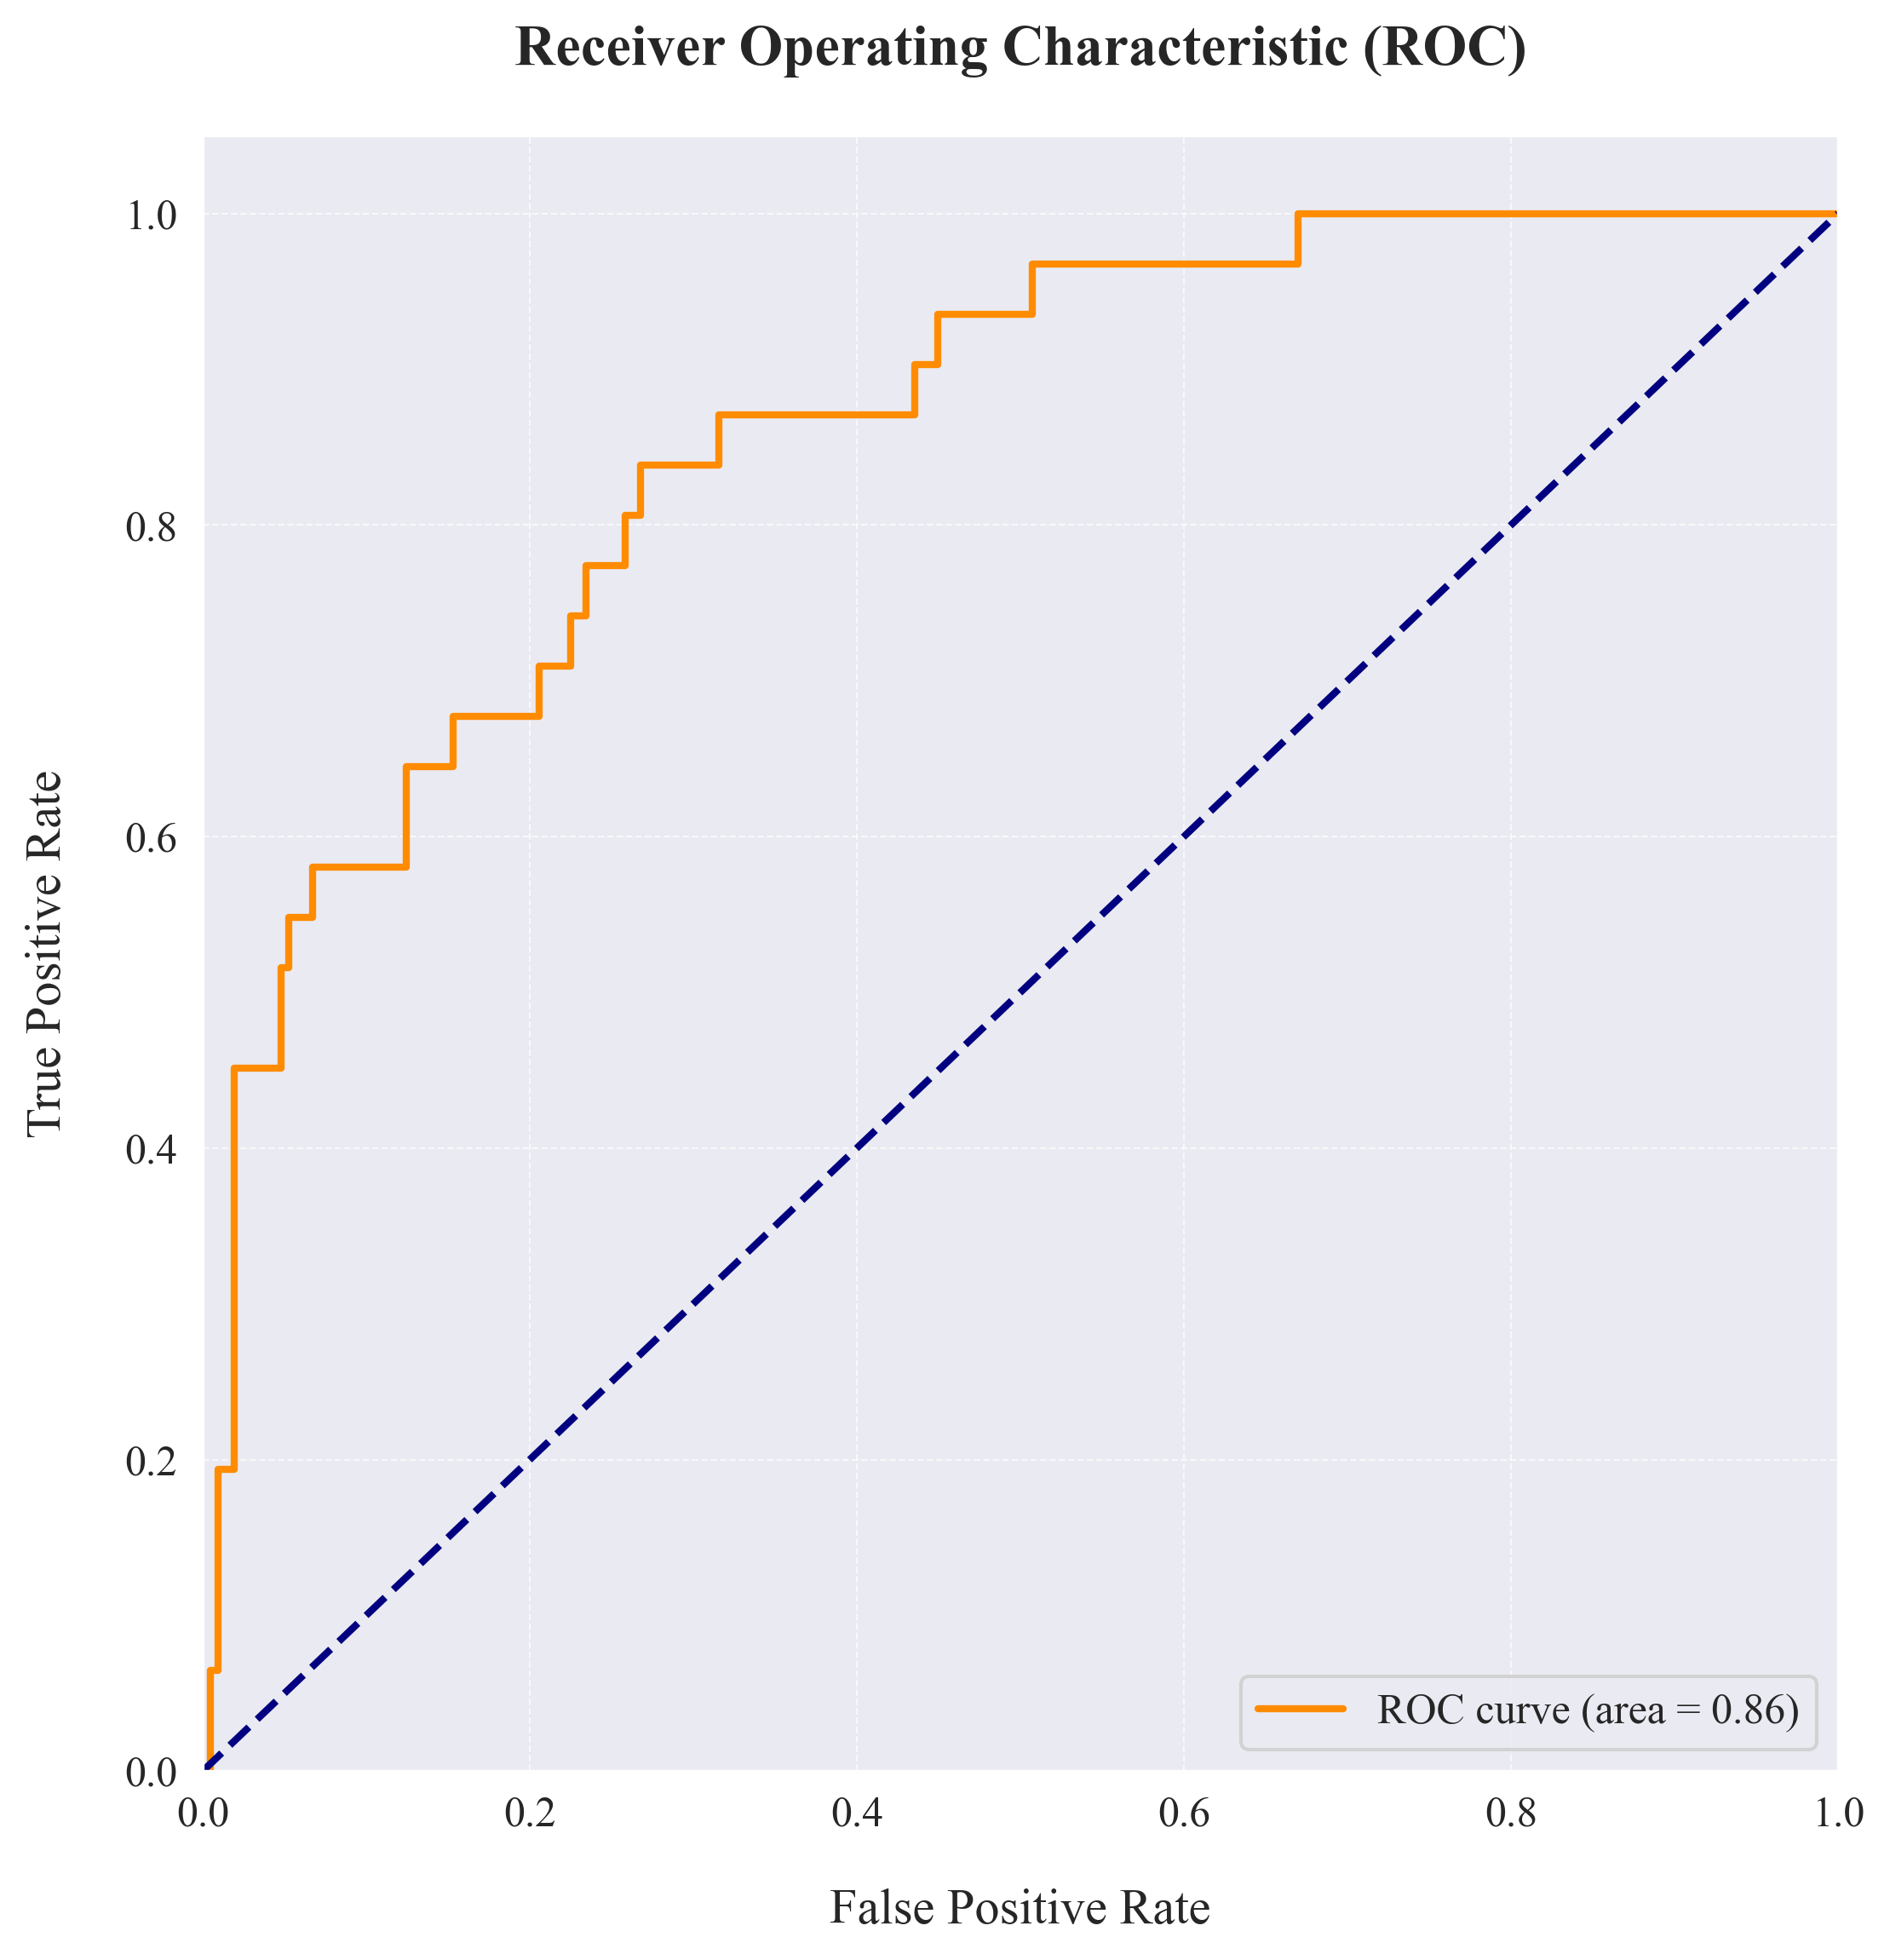

In [172]:
# draw the ROC curve
from sklearn.metrics import roc_curve, auc
# get the predicted probability
y_score = lr.predict_proba(X_test)[:, 1]
# calculate the fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# calculate the AUC
roc_auc = auc(fpr, tpr)
# draw the ROC curve
plt.figure(figsize=(8, 8), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=15)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=15)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('roc_lr.png')

In [173]:
# use SVM to train the model
from sklearn.svm import SVC
# initialize the model
svc = SVC(random_state=123456, probability=True, kernel='linear')
# train the model
svc.fit(X_resampled, y_resampled)

SVC(kernel='linear', probability=True, random_state=123456)

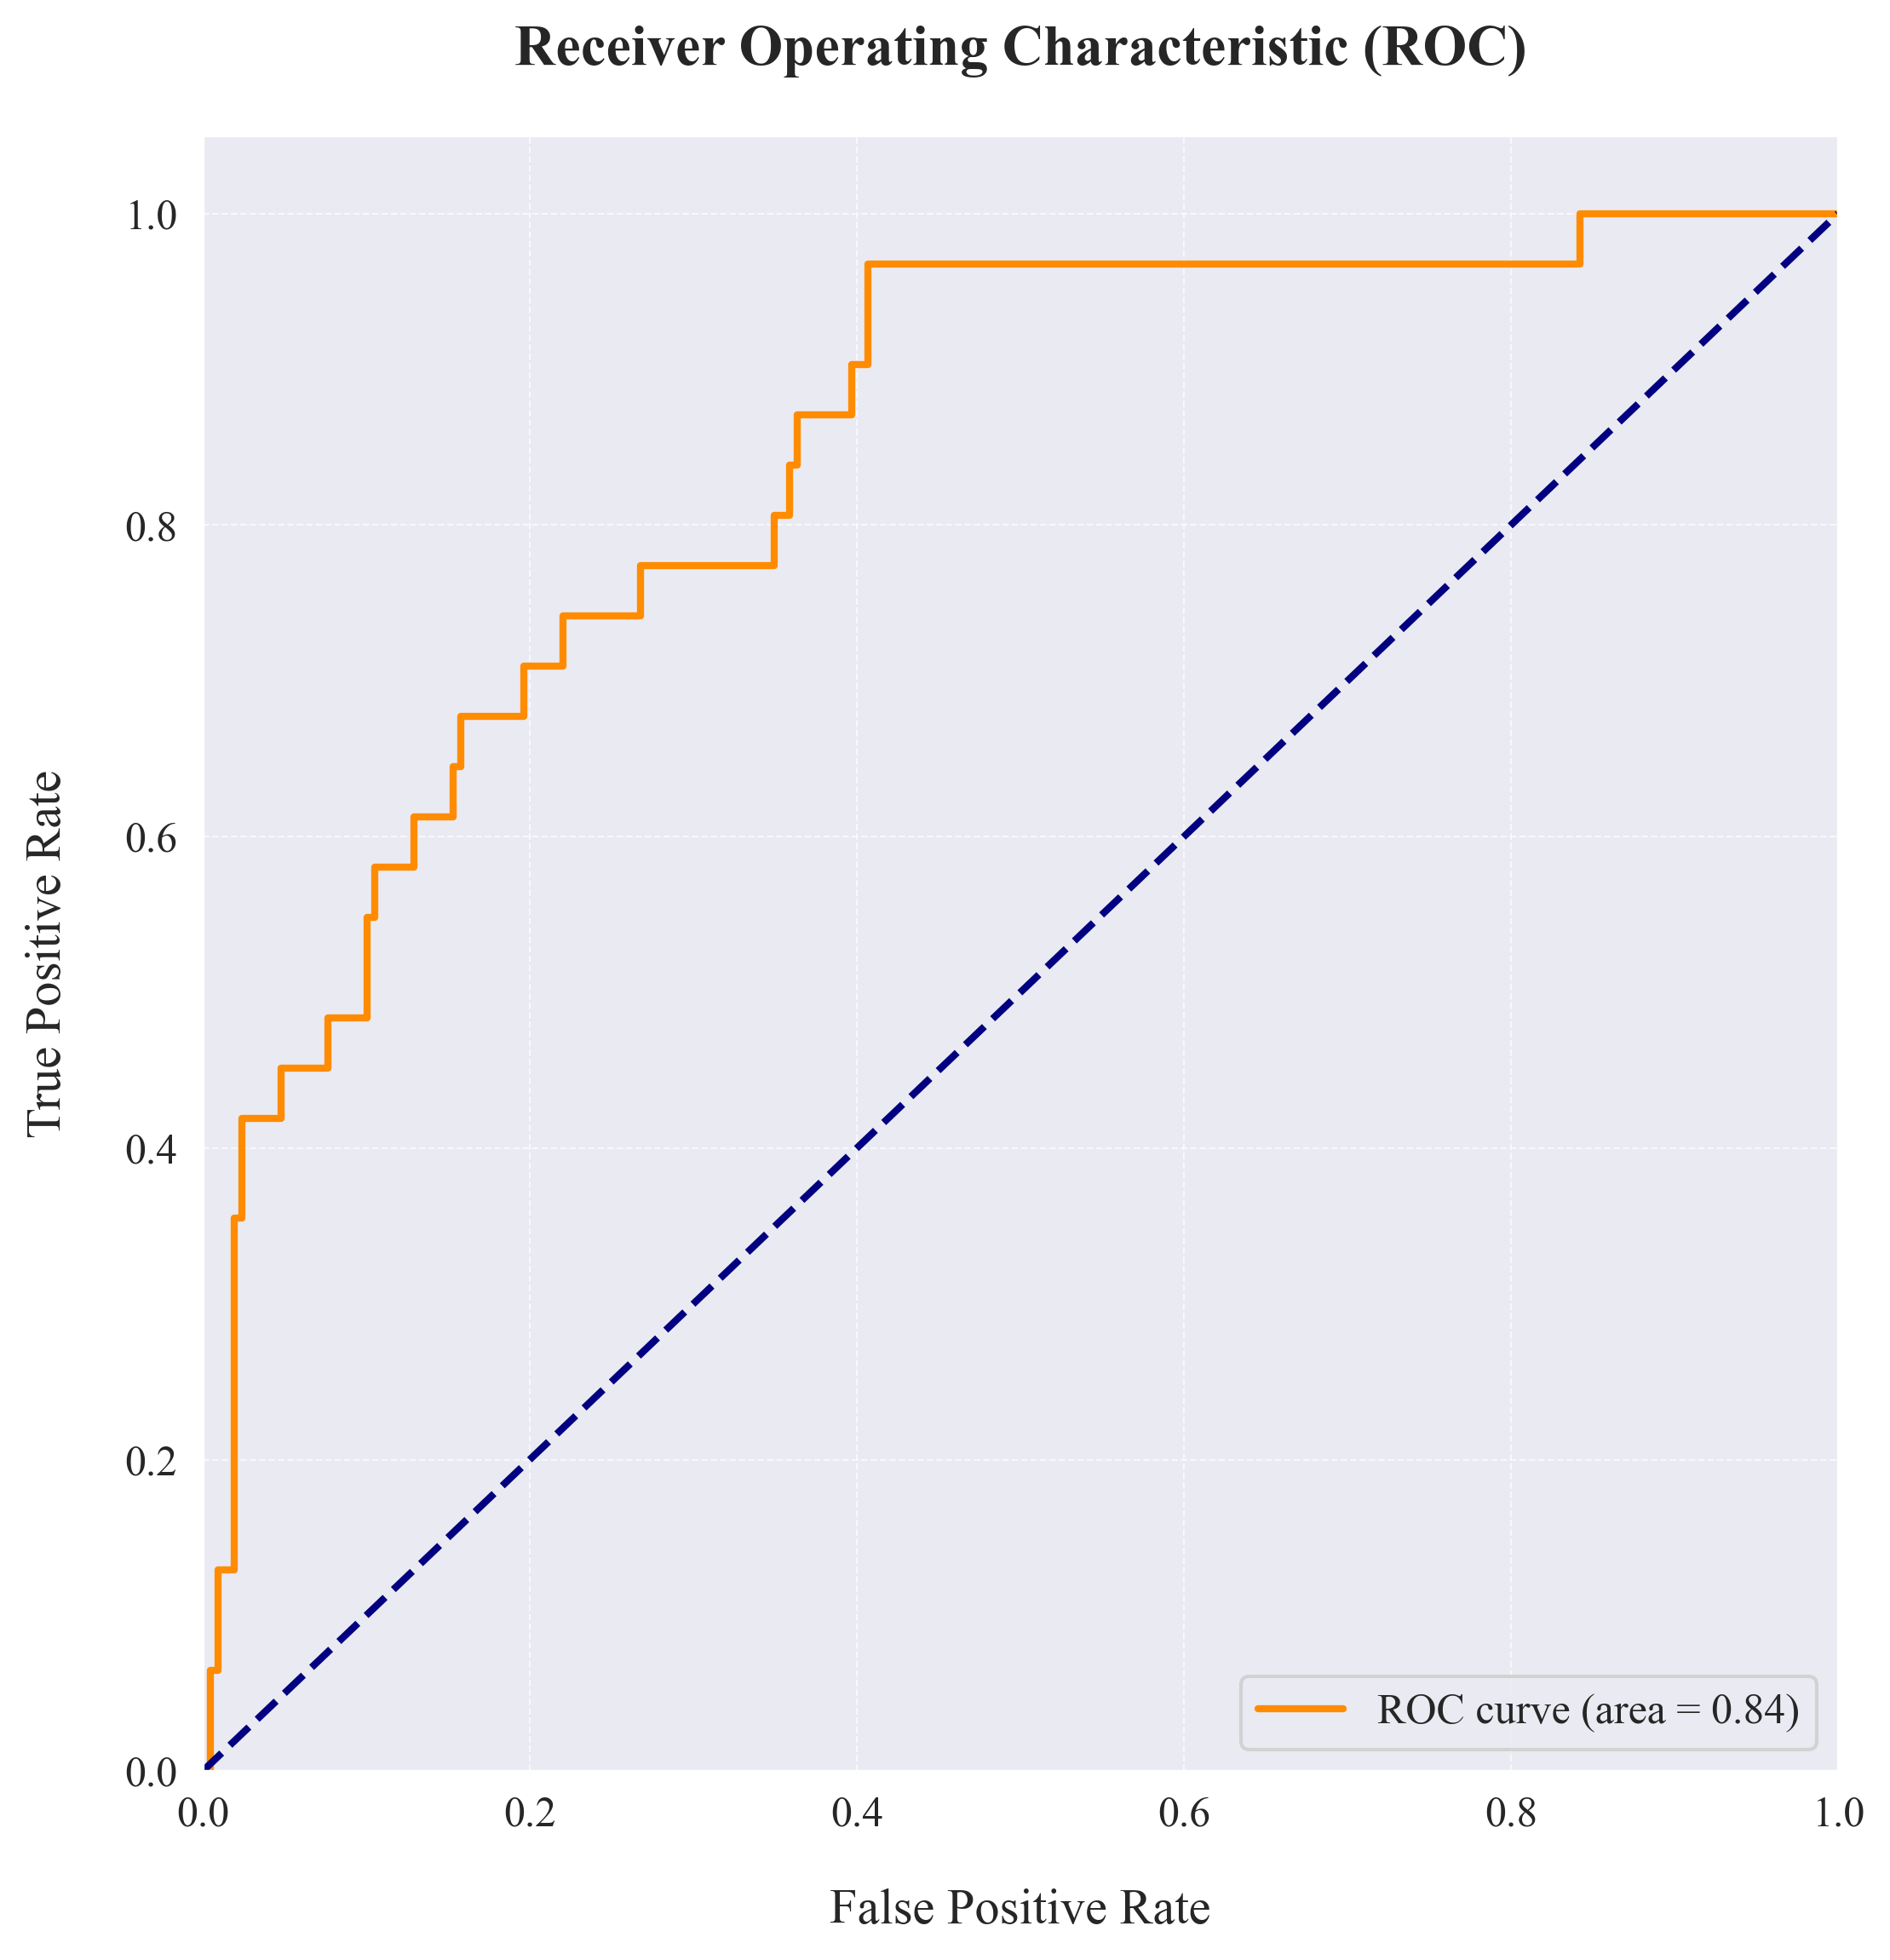

In [174]:
# draw the ROC curve
# get the predicted probability
y_score = svc.predict_proba(X_test)[:, 1]
# calculate the fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# calculate the AUC
roc_auc = auc(fpr, tpr)
# draw the ROC curve
plt.figure(figsize=(8, 8), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=15)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=15)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('roc_svm.png')

In [175]:
# train a MLP model
from sklearn.neural_network import MLPClassifier
# initialize the model
mlp = MLPClassifier(random_state=123456,max_iter=1000)
# train the model
mlp.fit(X_resampled, y_resampled)

MLPClassifier(max_iter=1000, random_state=123456)

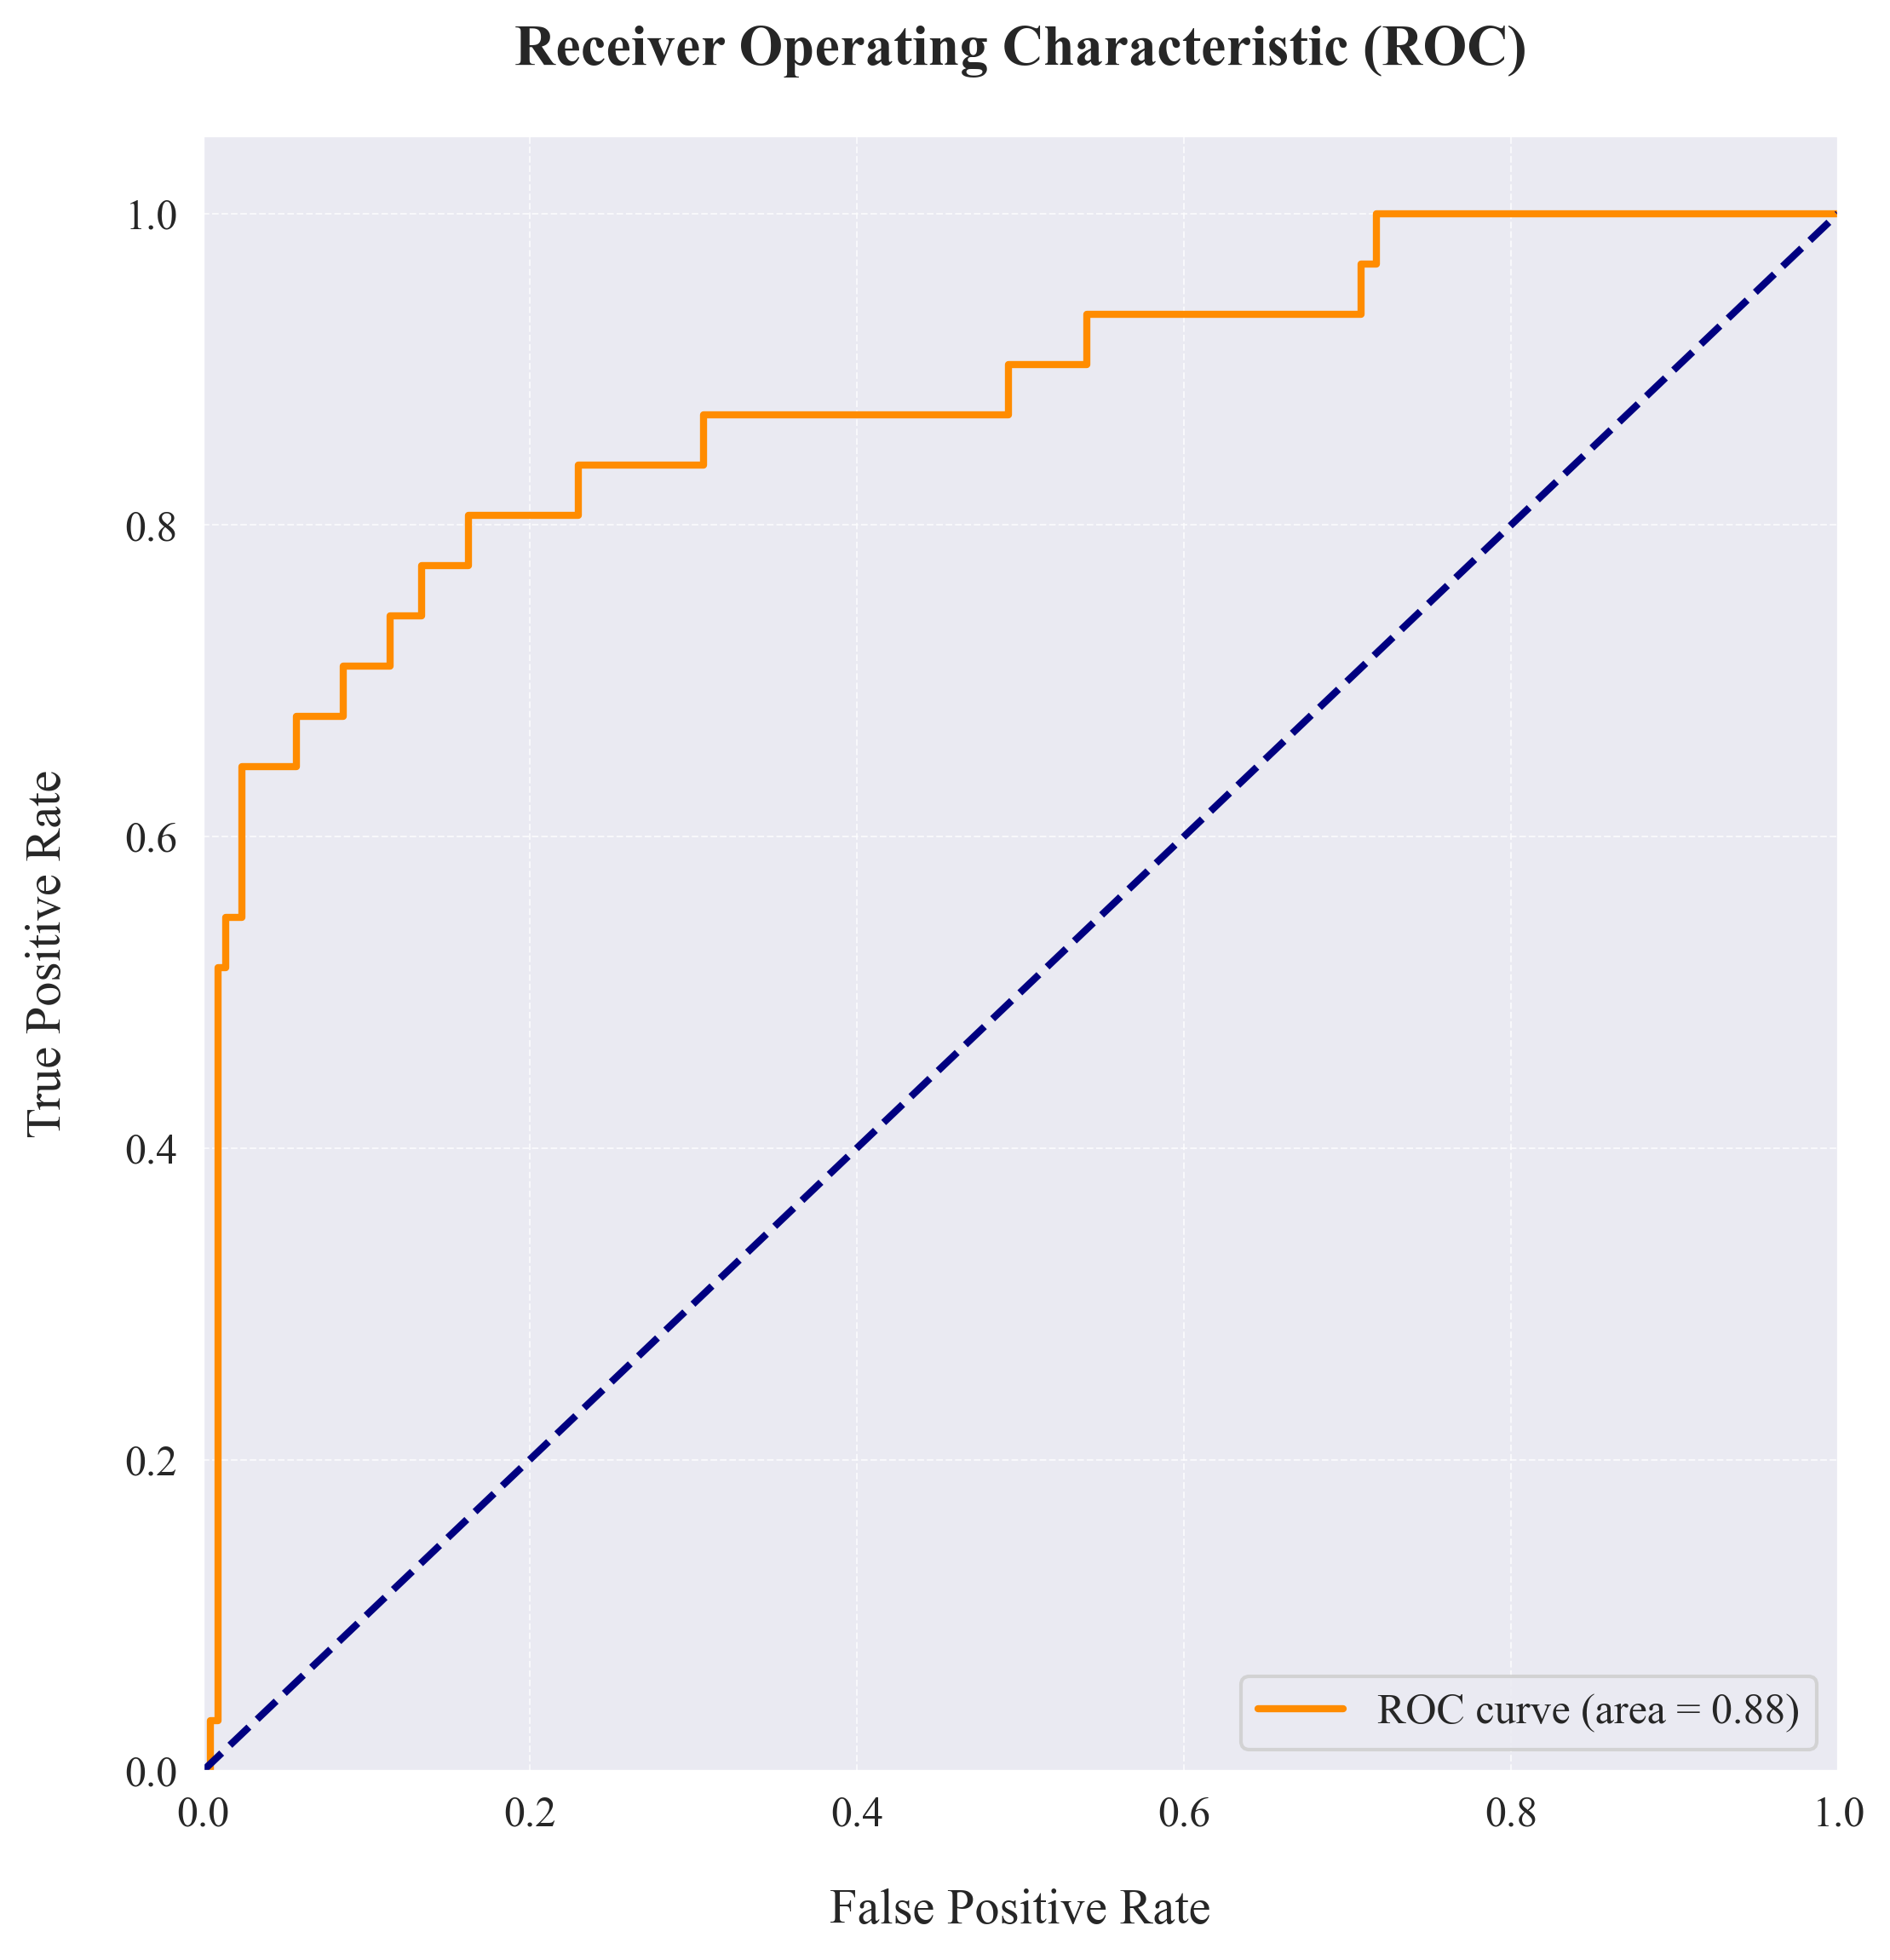

In [176]:
# draw the ROC curve
# get the predicted probability
y_score = mlp.predict_proba(X_test)[:, 1]
# calculate the fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# calculate the AUC
roc_auc = auc(fpr, tpr)
# draw the ROC curve
plt.figure(figsize=(8, 8), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=15)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=15)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('roc_mlp.png')

In [177]:
# train a naive bayes model
from sklearn.naive_bayes import GaussianNB
# initialize the model
nb = GaussianNB()
# train the model
nb.fit(X_resampled, y_resampled)

GaussianNB()

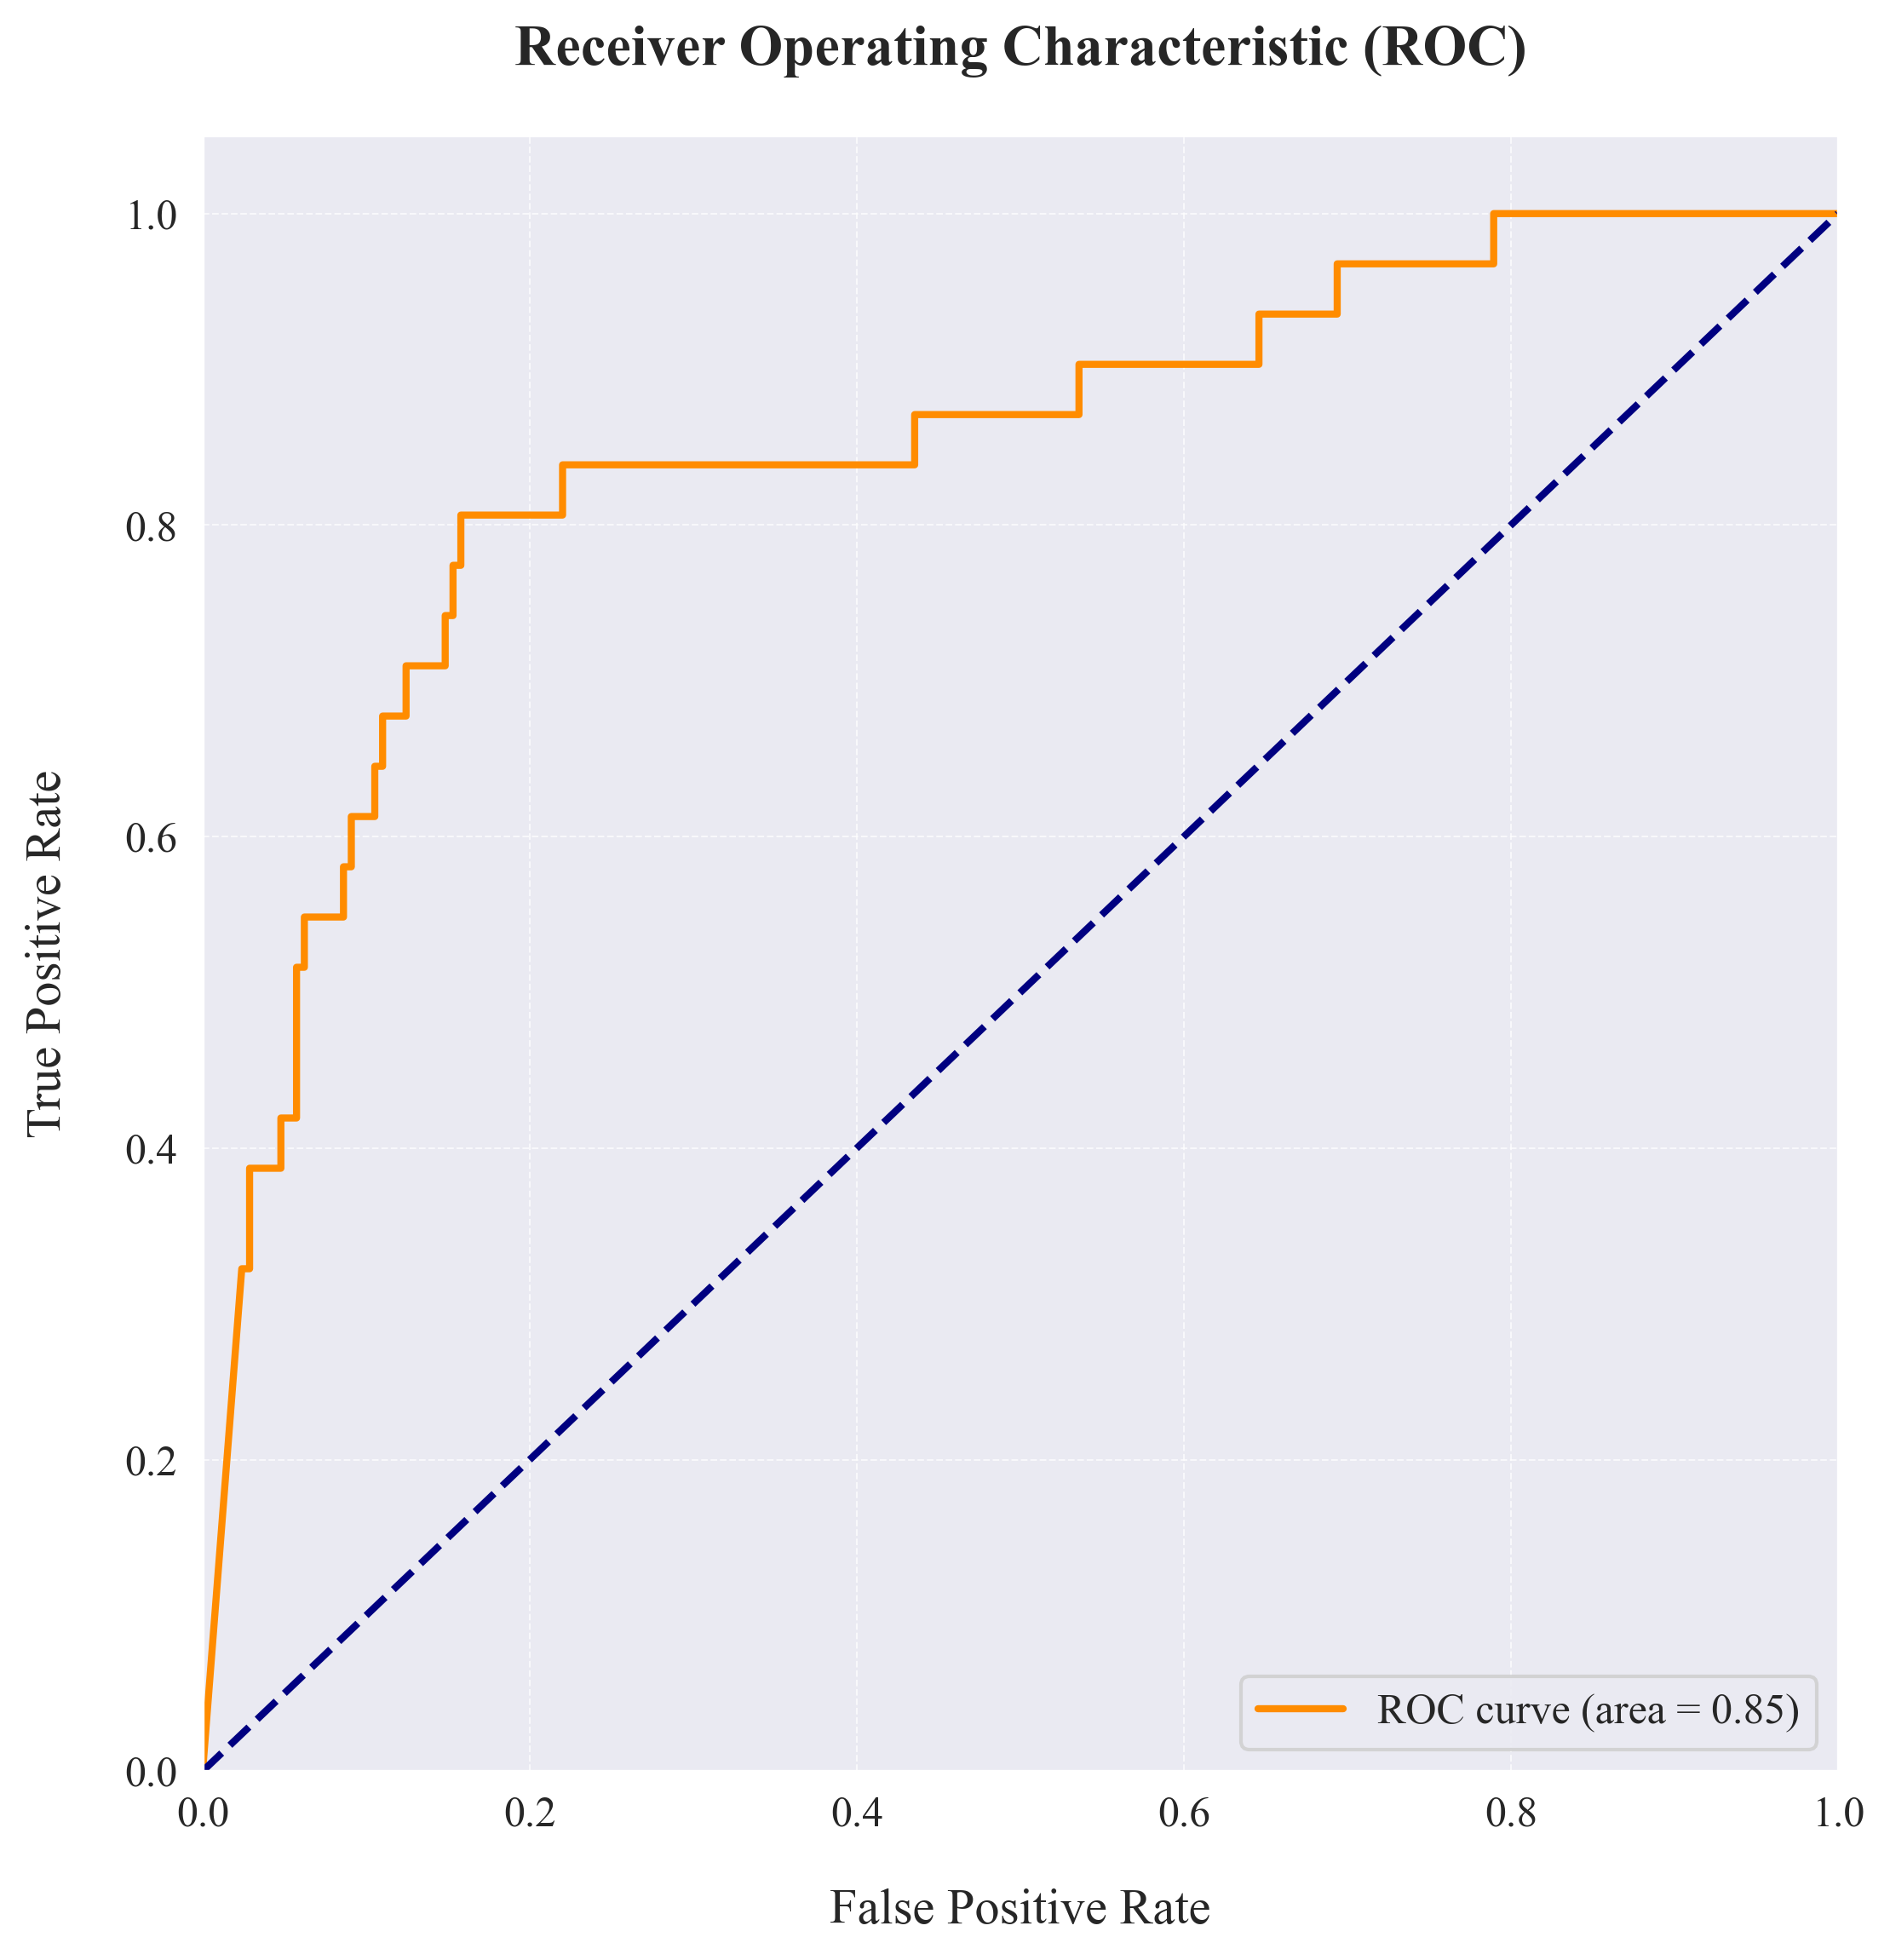

In [178]:
# draw the ROC curve
# get the predicted probability
y_score = nb.predict_proba(X_test)[:, 1]
# calculate the fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# calculate the AUC
roc_auc = auc(fpr, tpr)
# draw the ROC curve
plt.figure(figsize=(8, 8), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=15)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=15)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('roc_nb.png')

In [179]:
# train a xgboost model
from xgboost import XGBClassifier
# initialize the model
xgb = XGBClassifier()
# train the model
xgb.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

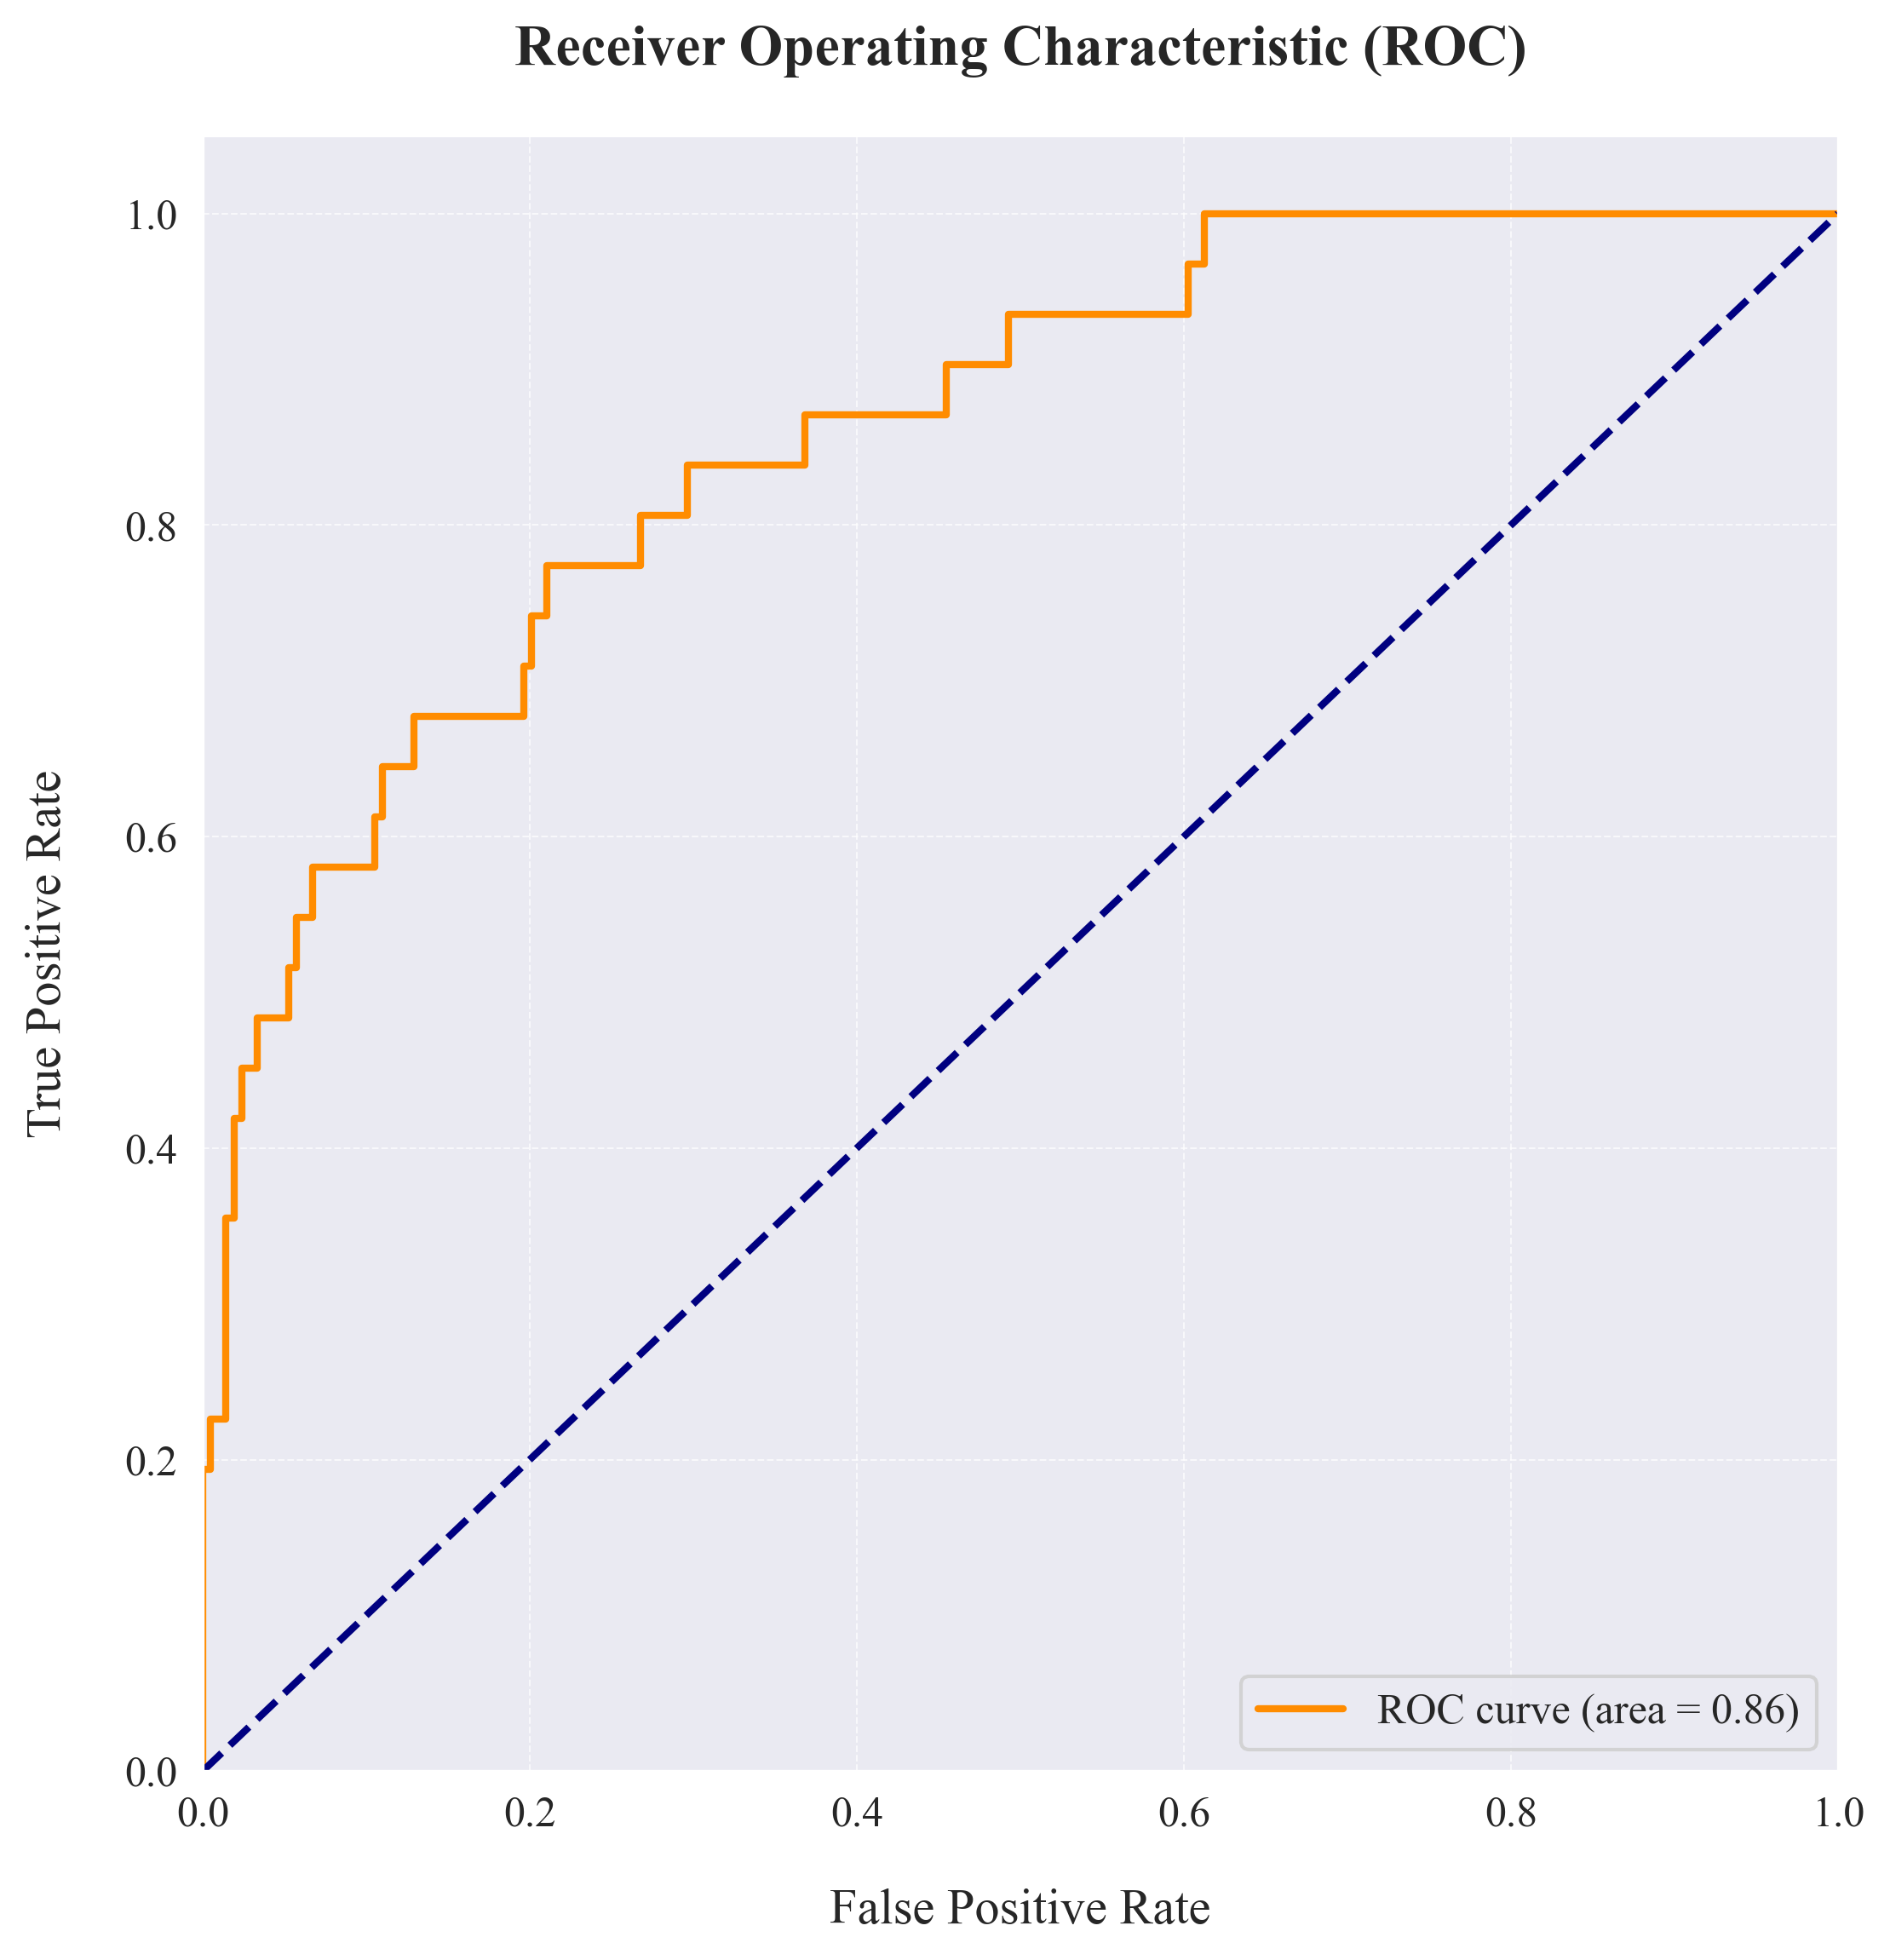

In [180]:
# draw the ROC curve
# get the predicted probability
y_score = xgb.predict_proba(X_test)[:, 1]
# calculate the fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# calculate the AUC
roc_auc = auc(fpr, tpr)
# draw the ROC curve
plt.figure(figsize=(8, 8), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=15)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=15)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('roc_xgboost.png')

In [181]:
# lightGBM model
from lightgbm import LGBMClassifier
# initialize the model
# use grid search to find best parameters
lgb = LGBMClassifier(   boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split')
# train the model
lgb.fit(X_resampled, y_resampled)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 746, number of negative: 495
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8025
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.601128 -> initscore=0.410168
[LightGBM] [Info] Start training from score 0.410168


LGBMClassifier(n_jobs=-1, reg_alpha=0, silent=True)

[LightGBM] [Warning] Unknown parameter: silent


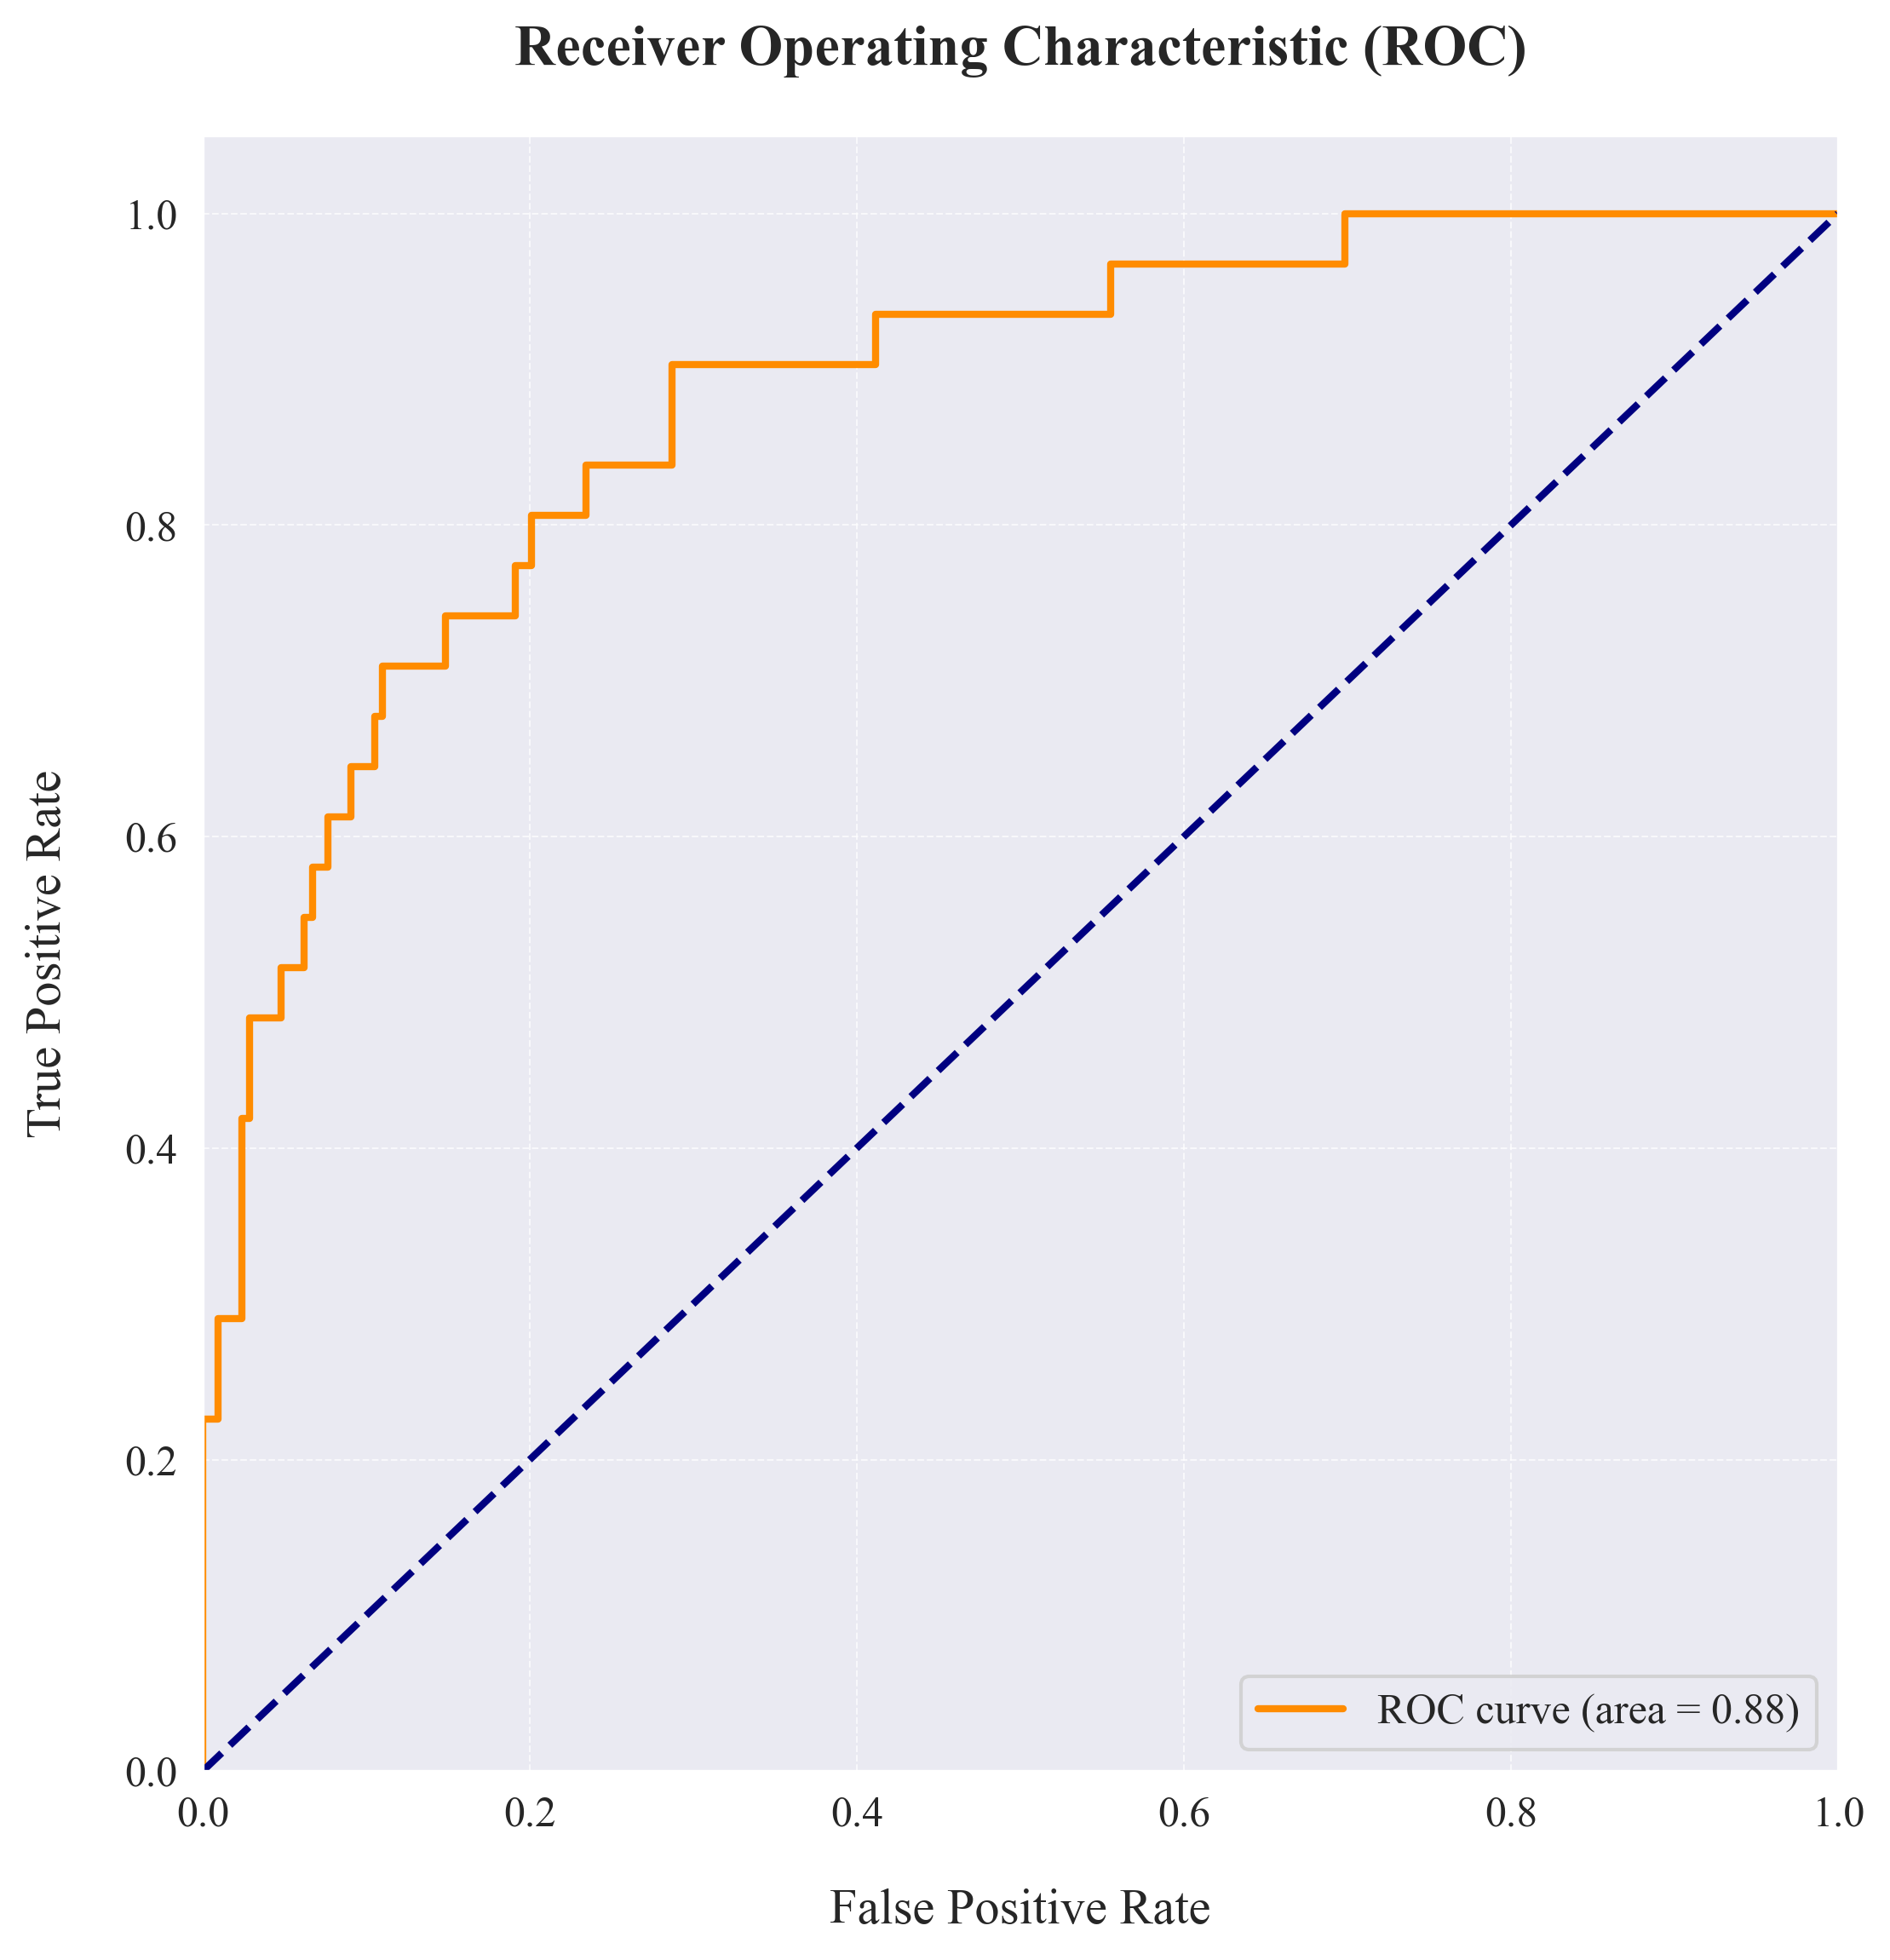

In [182]:
# draw the ROC curve
# get the predicted probability
y_score = lgb.predict_proba(X_test)[:, 1]
# calculate the fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# calculate the AUC
roc_auc = auc(fpr, tpr)
# draw the ROC curve
plt.figure(figsize=(8, 8), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=15)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=15)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('roc_lightgbm.png')

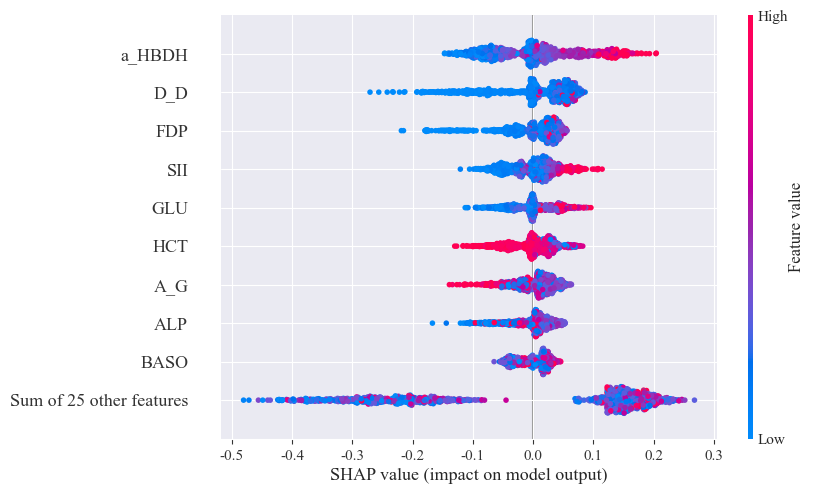

In [183]:
# use shap to explain the lr model
import shap
# initialize the explainer
# model is xgboost, should use explainer = shap.TreeExplainer(ada)
explainer = shap.TreeExplainer(lgb, X_resampled, model_output='probability')
shap_values = explainer.shap_values(X_resampled)
# get the importance of each feature
# repeat the deleted
shap_values_1 = shap_values[:, :]
# 将shap_values_1转换为Explanation对象
shap_values_Explanation = shap.Explanation(values=shap_values_1, data=X_resampled, feature_names=df_selected.columns)
# draw beewarm plot
shap.plots.beeswarm(shap_values_Explanation)

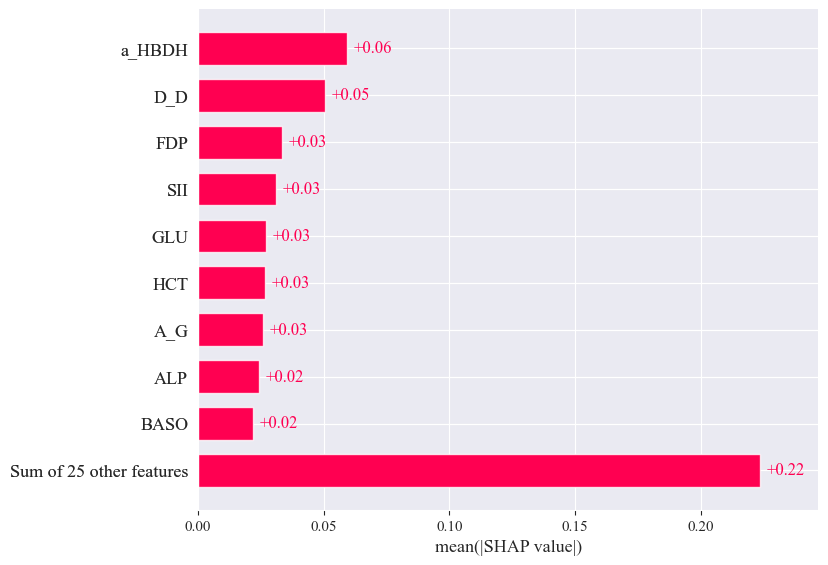

In [184]:
# draw histogram  of the shap values
shap.plots.bar(shap_values_Explanation)